In [ ]:
!pip3 install pandas
!pip3 install numpy
!pip3 install python-dp
!pip3 install matplotlib
!pip3 install seaborn

# A Quick Demo & Tutorial on Anonymization (using 🐍)

In this quick Tutorial, we will illustrate some well-known anonymization techniques using some simple examples. We do so from a developer perspective and at the same time want to allow for a better understanding through interactive tinkering. For this purpose, we employ the python programming language and some broadly used packages. These are ensured to be installed above. In particular, this includes:

* [Pandas](https://pandas.pydata.org/), a function-rich framework for handling and managing data, which is the de-facto-standard used by Data scientists (which will be accessed below under the pd-shortcut)
* [Numpy](https://numpy.org/), a package for fast and advanced computations in Python (used via the NP shortcut)
* [PyDP](https://github.com/OpenMined/PyDP), a python wrapper around [Google's Differential Privacy Suite](https://github.com/google/differential-privacy) (simply used as dp).
* [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/), two packages commonly used together for easily drawing nice and mathematically function-rich diagrams

These packages need to be imported to our runtime first, at the same time declaring the shortcuts under which they shall be used. For the moment, we do so for the first two only, as we are not (yet) going to apply differential privacy or to plot diagrams etc:

In [2]:
import pandas as pd
import numpy as np

For illustrating anonymization techniques, we do, of course, first need some example data that is to be anonymized. Let us, thus, assume we have some sample data representing student grades reached within a particular course. Students have a unique numerical identifier - a matriculation number - and a name. In addition, let us assume we know in which of their semesters students took the course and the grade they got.

We therefore first create a python data structure representing these example data and create a pandas DataFrame from this structure. This Dataframe will be used in the following for working on our example data. We name this initial DataFrame ```student_df``` and print it:

In [3]:
student_data = {"Matr": [12345, 23456, 34567, 45678, 56789, 67890, 78901, 89012, 90123, 12346, 23457, 34568, 45679], 
                "Name": ["name0", "name1", "name2", "name3", "name4", "name5", "name6", "name7", "name8", "name9", "nameA", "nameB", "nameC"], 
                "Semester": [3, 5, 7, 2, 11, 14, 1, 6, 5, 3, 5, 11, 9], 
                "Grade": [2.3, 2.3, 2.0, 3.0, 1.0, 1.3, 2.3, 1.7, 3.3, 1.0, 2.0, 1.3, 3.3]}
student_df = pd.DataFrame(data=student_data)
student_df

,Matr,Name,Semester,Grade
0,12345,name0,3,2.3
1,23456,name1,5,2.3
2,34567,name2,7,2.0
3,45678,name3,2,3.0
4,56789,name4,11,1.0
5,67890,name5,14,1.3
6,78901,name6,1,2.3
7,89012,name7,6,1.7
8,90123,name8,5,3.3
9,12346,name9,3,1.0


Ok, looks nice.

## Naïve De-Personalization

Now we start de-personalizing our dataset. For this, we create a function that just drops those colums that contain explicit identifiers - the Matr and the Name column. We then copy our initial DataFrame, de-personalize it using our function, and store it in a new DataFrame ```student_df_depers```. Again, we print it to ensure everything works as intended:

In [4]:
def depersonalize_student_df(df_to_depersonalize):
    #return df_to_depersonalize.drop("Matr", 1).drop("Name", 1) # remove Matr.-Nr. and Name columns
    #reason https://stackoverflow.com/questions/76411055/typeerror-dataframe-drop-takes-from-1-to-2-positional-arguments-but-3-were-gi
    return df_to_depersonalize.drop("Matr", axis=1).drop("Name", axis=1)    
student_df_depers = depersonalize_student_df(student_df.copy())
student_df_depers

,Semester,Grade
0,3,2.3
1,5,2.3
2,7,2.0
3,2,3.0
4,11,1.0
5,14,1.3
6,1,2.3
7,6,1.7
8,5,3.3
9,3,1.0


Works as intended: We now have a dataset without any names or explicit ID numbers (which could, of course, also have been passport numbers etc.) included. One could assume that our dataset is now anonymized and the privacy of the covered students is nicely protected (in fact -- and sadly -- this is what non-privacy-people often think is enough to sufficiently anonymize a dataset). 

## *k*-Anonymity 

However, we still have so-called quasi-identifiers in this dataset. Put briefly, such quasi-identifiers are values included in a dataset that still allow to re-identify the person behind the datapoint (at least with some certainty) because the combination is so rare in a given context that only one person actually exhibits it. [Sweeny (2002)](https://scholar.google.com/scholar?cluster=5874809758453902851&hl=en&as_sdt=0,5) provides the illustrative example of having been able to re-identify persons from insufficiently anonymized health data by simply mapping included combinations of ZIP-code, birthday, and sex against a public voter database.

In our student example, a similar effect would, for instance, happen when the insufficiently anonymized dataset is made publicly available and when it is known by one party B (possibly a co-student of party A) that A participated in the course in their 14th semester. B could then conclude that A got a 1.3 in this course. 

Just removing explicit identifiers from a dataset is thus obviously not enough. Instead, we also have to avoid "uniqueness" of de-personalized datapoints included in our dataset. In this regard, [Sweeny (2002)](https://scholar.google.com/scholar?cluster=5874809758453902851&hl=en&as_sdt=0,5) introduced the concept of *k*-anonymity. Put briefly, *k*-anonymity is about generalizing / abstracting data in such a way that some datapoints become indistinguishable based on the quasi-identifiers (this excludes those parts of the data that can legitimately assumed to not appear elsewhere -- in our case: the grades). Such generalization can be done by abstracting a birthday into a range of birth, cutting off digits from ZIP codes, etc. 

*k*-anonymity then means that each group of "indistinguishable" data points contains at least *k* entries. Several algorithms exist to *k*-anonymize data efficiently, but these shall not be considered in-depth herein. Let us, for illustrative purposes, assume that we somehow concluded what needs to be done to achieve a *k* of 3 for our example dataset: We just have to mask matriculation numbers and names and then group semesters of attendance into four clusters: Cluster 1 with semesters 4 and below, cluster 2 for semester 5, cluster 3 for semesters 6 to 9, and cluster 4 for semesters 10 and above. 

We define a respective anonymization function, apply it to a copy of our initial dataset and store the result in a new DataFrame ```student_df_k_anon``` which now contains *k*-anonymized student data with *k*=3:

In [5]:
def k_anonymize_student_df(df_to_k_anonymize):
    # instead of actually applying an existing k-anon algorithm, we assume we know
    # the generalization operations to be applied so that each group contains at least 3 entries:
    # - mask Matr and Name colums
    df_to_k_anonymize.loc[(df_to_k_anonymize["Matr"].notnull()), "Matr"] = np.nan # replace all numbers in Matr with NaN
    df_to_k_anonymize.loc[(df_to_k_anonymize["Name"] != "---"), "Name"] = "---" # blank all names
    # - group semester entries into (0-4) - (5) - (6-9) - (>= 10)
    df_to_k_anonymize.loc[(df_to_k_anonymize["Semester"] <= 4), "Semester"] = 1 # lowest semester group
    df_to_k_anonymize.loc[(df_to_k_anonymize["Semester"] == 5), "Semester"] = 2 # 2nd lowest semester group
    df_to_k_anonymize.loc[(df_to_k_anonymize["Semester"].between(6, 9)), "Semester"] = 3 # 3rd lowest semester group
    df_to_k_anonymize.loc[(df_to_k_anonymize["Semester"] >= 10), "Semester"] = 4 # 2nd lowest semester group
    df_to_k_anonymize.rename(columns={"Semester": "Semester-Group"}, inplace = True)
    
    return df_to_k_anonymize

student_df_k_anon = k_anonymize_student_df(student_df.copy())
student_df_k_anon

,Matr,Name,Semester-Group,Grade
0,NaN,---,1,2.3
1,NaN,---,2,2.3
2,NaN,---,3,2.0
3,NaN,---,1,3.0
4,NaN,---,4,1.0
5,NaN,---,4,1.3
6,NaN,---,1,2.3
7,NaN,---,3,1.7
8,NaN,---,2,3.3
9,NaN,---,1,1.0


So, we now have a k-anonymized set of student data where we cannot re-identify individual contained persons due to the applied generalization / grouping of semesters of attendance. 

# *l*-Diversity

However, there are still several attacks possible for such datasets. Some -- as well as respective counterstrategies -- are already laid out by [Sweeny (2002)](https://scholar.google.com/scholar?cluster=5874809758453902851&hl=en&as_sdt=0,5), but let us herein only focus on the following: Assume we know that A attended the course in thei 14th semester. Due to *k*-anonymization, we cannot identify A's datapoint in the dataset. However, we can -- due to the specific distribution in the dat at hand -- still say that, knowing that semester 14 is in group 4, A must either have received a 1.3 or a 1.0, which both boil down to a 1. 

The problem here is that the sensitive data (the grades) are not sufficientyl diverse within at least one cluster, still revealing information about A's grade. For addressing such situations, [Machanavajjhala et al (2007)](https://scholar.google.com/scholar?cluster=3215471666469750915&hl=en&as_sdt=0,5) introduced the concept of *l*-diversity. Beyond *k*-anonymity, *l*-diversity requires that generalization/aggregation is conducted in such a way that each of the resulting clusters / groups contains at least *l* different sensitive values (in our case: grades). 

Again, there are existing algorithms for ensuring *l*-diversity but again, let's assume we know what needs to be done to achieve an *l* of 3 (assuming that this *l* needs to be achieved for integer grades): Mask names and matriculation numbers and group semesters of attendance into "5 and below" and "6 and above". Again, we define a function that does so and apply it to our initial dataset:

In [6]:
def l_diversify_student_df(df_to_l_diversify):
    # instead of actually applying an existing l-diversity algorithm, we assume we know
    # the generalization operations to be applied so that each group contains at least 3 different grades:
    # - again mask Matr and Name columns:
    df_to_l_diversify.loc[(df_to_l_diversify["Matr"].notnull()), "Matr"] = np.nan
    df_to_l_diversify.loc[(df_to_l_diversify["Name"] != "---"), "Name"] = "---"
    # - group semester entries into (0-5) - (>= 6)
    df_to_l_diversify.loc[(df_to_l_diversify["Semester"] <= 5), "Semester"] = 1 # lowest semester group
    df_to_l_diversify.loc[(df_to_l_diversify["Semester"] >= 6), "Semester"] = 2 # 2nd lowest semester group
    df_to_l_diversify.rename(columns={"Semester": "Semester-Group"}, inplace = True)
    # - we may also round grades to integers, but this is not necessary for l
    #df_to_l_diversify = df_to_l_diversify.round({"Grade": 0})
    return df_to_l_diversify

student_df_l_diverse = l_diversify_student_df(student_df.copy())
student_df_l_diverse

,Matr,Name,Semester-Group,Grade
0,NaN,---,1,2.3
1,NaN,---,1,2.3
2,NaN,---,2,2.0
3,NaN,---,1,3.0
4,NaN,---,2,1.0
5,NaN,---,2,1.3
6,NaN,---,1,2.3
7,NaN,---,2,1.7
8,NaN,---,1,3.3
9,NaN,---,1,1.0


Voila! We now also have an *l*-diverse representation of our initial dataset in addition to the previously created *k*-anonymous one. Great!

But, well..., what are we doing all this for? Seems like we are loosing a lot of valuable information with our ever-escalating generalizations, right?

To a certain extent, yes. But still, we are able to do meaningful analyses on the so-anonymized data. Assume, for instance, you are the person responsible for monitoring and increasing student success in the school offering the course we are looking at. You might not be legitimized to know the individual grades of students and the lecturer may thus not provide the raw data to you. However, depending on a variety of factors, handing over *k*-anonymous or *l*-diverse data to you might be ok.

As it turns out, such datasets still allow to draw conclusions about the correlation between the semester of attendance and the achieved grade. For this purpose, we first calculate the overall mean of grades across all students. Second we calculate the mean grades per cluster / group in the *k*-anonymous as well as in the *l*-diverse dataset (yes, some pandas magic included... 🤓):

In [7]:
mean_grade_overall = student_df["Grade"].mean()
mean_grades_per_sem_group_k_anon = student_df_k_anon[["Semester-Group", "Grade"]].groupby("Semester-Group").mean()
mean_grades_per_sem_group_l_diverse = student_df_l_diverse[["Semester-Group", "Grade"]].groupby("Semester-Group").mean()
print("Overall mean grade: %s\n" % mean_grade_overall)
print("Mean grades per k-anonymized semester groups:\n%s\n" % mean_grades_per_sem_group_k_anon)
print("Mean grades per l-diversified semester groups:\n%s" % mean_grades_per_sem_group_l_diverse)

Overall mean grade: 2.0615384615384618

Mean grades per k-anonymized semester groups:
                   Grade
Semester-Group          
1               2.150000
2               2.533333
3               2.333333
4               1.200000

Mean grades per l-diversified semester groups:
                   Grade
Semester-Group          
1               2.314286
2               1.766667


As we can see, *k*-anonymized and *l*-diversified data still provides analytical value without (overly) exposing the individuals whose personal data is contained. We can, for instance, say that, according to the *l*-diverse dataset, higher semesters on average reach better grades in this particular course while the *k*-anonymous dataset indicates that those students taking the course in one of the four semesters nonetheless perform slightly better than those in the two middle groups and even underpins the conclusion that students with late semesters of attendance reach significantly better grades.

*k*-anonymity as well as *l*-diversity thus ensure a well-defined level (and kind) of privacy (or, to be more precise, anonymity) while still allowing for meaningful analyses upon respectively preprocessed data. There is an additional concept of *t*-closeness, which shall not be addressed herein. But feel free to research it and to apply it to our example data yourself.

## The risk of repeated releases

Still, though, releasing data in (*k*-anonymous or) *l*-diverse form does not come without risks. In particular, this is the case when data is repeatedly released and when changes are applied between two such releases. Assume, for instance, we have our initial raw dataset and the *l*-diverse dataset derived from it. Now, an additional student (studentX) -- who could not attend the exam because of being sick -- writes a separate exam and is added to the original raw dataset. We then again generate a (second) *l*-diverse representation and again hand it over to the "student success officer":

In [8]:
studentX = [56780, "nameD", 7, 5.0] 
student_df2 = student_df.copy()
student_df2.loc[len(student_df2)] = studentX
student_df2_l_diverse = l_diversify_student_df(student_df2.copy())
student_df2_l_diverse

,Matr,Name,Semester-Group,Grade
0,NaN,---,1,2.3
1,NaN,---,1,2.3
2,NaN,---,2,2.0
3,NaN,---,1,3.0
4,NaN,---,2,1.0
5,NaN,---,2,1.3
6,NaN,---,1,2.3
7,NaN,---,2,1.7
8,NaN,---,1,3.3
9,NaN,---,1,1.0


When calculating the mean grade from this new *l*-diversified dataset and comparing it to the overall mean from the initially created one, we see a significant drop:

In [9]:
mean_grade_initial = student_df_l_diverse["Grade"].mean()
mean_grade_appended = student_df2_l_diverse["Grade"].mean()
print("Mean grades:\nDataset 1 (excl. X): %s\nDataset 2 (incl. X): %s" %(mean_grade_initial, mean_grade_appended))

Mean grades:
Dataset 1 (excl. X): 2.0615384615384618
Dataset 2 (incl. X): 2.2714285714285714


If the "student success officer" knows that it was a particular student who separately wrote the exam later can thus easily conclude that this student got a grade that is, at least, significantly below the mean grad of all other students attending the same course. Even though *l*-diversified, this dataset thus reveals potentially critical information about student X.

One approach for countering such risks while still allowing to conduct meaningful and valuable analyses on respective data is "Differential Privacy". Brought forward by researchers such as [Dwork and Roth (2014)](https://scholar.google.com/scholar?cluster=15281065433928134483&hl=en&as_sdt=0,5), differential privacy has gained significant attention in academia and industry alike over the past few years. We will thus take a closer look at how differential privacy works and how it can be used below.

## Enter Differential Privacy

The basic ideas and concepts behind differential privacy can hardly be explained in a few lines. A quite conceivable introduction has, for instance, been given by [Wood et al. (2018)](https://scholar.google.com/scholar?cluster=5713053704431991604&hl=en&as_sdt=0,5).

Put (very) briefly, differential privacy follows the idea of only releasing aggregate results of queries (such as means, sums, ...) on privacy-sensitive data and adding "noise" to these results in order to avoid the above-mentioned problem of similar queries being made to slightly differing datasets. Without deep-diving into the formal definitions (on this, see again [Wood et al. (2018)](https://scholar.google.com/scholar?cluster=5713053704431991604&hl=en&as_sdt=0,5) or, even more formally, [Dwork and Roth (2014)](https://scholar.google.com/scholar?cluster=15281065433928134483&hl=en&as_sdt=0,5)), differential privacy ensures that the probabilities p and p' for a certain query result to be returned for two datasets D and D' -- which only differ by the existence of one entry, such as studentX from our above example -- are very similar. The similarity of these probabilities, in turn, is defined by a parameter named epsilon. Again without deep-diving into the formal definitions etc., a lower epsilon means a higher similarity in the (randomized) distribution of results returned for D and D'. Low epsilons thus lead to a lower severity of above-sketched risks and, in the end, a higher level of privacy / anonymity.

Confused? Understandable. Let's illustrate what happens based on our established student example again:

For illustrating the application and the effects of differential privacy, we first need an implementation of said "noising" mechanisms or, more specifically, of an algorithm producing differentially private results. Luckily, we do not have to implement those algorithms ourself but can use a ready-made python-package: [PyDP](https://github.com/OpenMined/PyDP), which wraps [Google's Differential Privacy Suite](https://github.com/google/differential-privacy) and makes it available in python. We thus import this package under the shortcut dp.

This package offers different "noising" algorithms. Basically, each of them provably ensures that the formal definition for differential privacy is met. At the same time, however, we also want the produced query results to be as accurate as possible (otherwise, we could simply always return a static value such as ```42```, which would also fulfill the formal criteria for differential privacy). A Laplacian distribution of probabilities (at what probability will which result be returned) provides quite a good accuracy here. As we will only calculate differentially private mean values in the following, we thus import PyDP's BoundedMean function in the "Laplacian flavor". Before, however, we have to to some setup and initializations to allow starting right here:


In [11]:
import pandas as pd
import numpy as np
student_data = {"Matr": [12345, 23456, 34567, 45678, 56789, 67890, 78901, 89012, 90123, 12346, 23457, 34568, 45679], 
                "Name": ["name0", "name1", "name2", "name3", "name4", "name5", "name6", "name7", "name8", "name9", "nameA", "nameB", "nameC"], 
                "Semester": [3, 5, 7, 2, 11, 14, 1, 6, 5, 3, 5, 11, 9], 
                "Grade": [2.3, 2.3, 2.0, 3.0, 1.0, 1.3, 2.3, 1.7, 3.3, 1.0, 2.0, 1.3, 3.3]}
student_df = pd.DataFrame(data=student_data)
studentX = [56780, "nameD", 7, 5.0] 
student_df2 = student_df.copy()
student_df2.loc[len(student_df2)] = studentX

import pydp as dp
from pydp.algorithms.laplacian import BoundedMean
best_possible_grade = 1
worst_possible_grade = 5

As you see, we also specified the boundaries of possible grades -- the best possible and the wors possible grade a student could achieve. Specifying those boundaries is not necessary but especially for quite small datasets like the one we are operating on so far, it eases things.

To get a first feeling about what differential privacy does and how, we now want to calculate the mean grades of our well-known student datasets, one without and one with studentX's grade included. For this purpose, we first define the above-mentioned parameter epsilon (remember, a lower epsilon means a higher level of privacy/anonymity). It is broadly agreed that epsilon values should be very small, way below 1. Given our quite small dataset, we first choose an epsilon of 0.3.

Based on these parameters, we now set up our differentially private mean function ```diff_priv_mean``` and ensure it works vor non-integer values. On this basis, we then calculate the differentially private mean of grades achiever within the two student datasets and compare them to the respective plain means:

In [38]:
# set up function producing randomized mean results based on laplacian distribution
# we can set different values for epsilon, producing different distributions and, thus, different levels of privacy
epsilon = 0.3
diff_priv_mean = BoundedMean(epsilon, lower_bound = best_possible_grade, upper_bound = worst_possible_grade, dtype="float")

mean_grade_plain1 = student_df["Grade"].mean()
mean_grade_diffPriv1 = diff_priv_mean.quick_result(list(student_df["Grade"]))
mean_grade_plain2 = student_df2["Grade"].mean()
mean_grade_diffPriv2 = diff_priv_mean.quick_result(list(student_df2["Grade"]))
print("Mean grades Dataset1 (excl. X):\nPlain   : %s\nDiffPriv: %s" %(mean_grade_plain1, mean_grade_diffPriv1))
print("Mean grades Dataset2 (incl. X):\nPlain   : %s\nDiffPriv: %s" %(mean_grade_plain2, mean_grade_diffPriv2))


Mean grades Dataset1 (excl. X):
Plain   : 2.0615384615384618
DiffPriv: 2.3141141488876507
Mean grades Dataset2 (incl. X):
Plain   : 2.2714285714285714
DiffPriv: 2.04500411864468


As we see, the differentially private results differ from the plain ones -- "more or less" and "in one direction or the other". This is the laplacian randomness at work. When we execute this code block several times, we see that and how the differentially private results change. 

Even though changing unpredictably, however, the differentially private results are in most cases "somewhat accurate" compared to the plain means. This allows us to gain comparably valuable results (allowing for meaningful analyses) even without allowing us to draw conclusions about studentX from querying the first and the second dataset (without and with studentX included) subsequently. Nice!

However, repeatedly executing this code block manually does not paint the whole picture about how our differentially private mean "behaves". To illustrate this, let's thus automate the repeated execution and plot some nice diagrams.

## Plotting Differentially Private Results

Given that differentially private means unpredictably differ from the plain ones "more or less" and "in one direction or the other", it is valuable to visualize how often which results are returned. For this, we use the established python packages matplotlib (and, in particular, the pyplot subpackage -- ```plt```) and seaborn (```sns```). Besides the epsilon parameter, we also define a binsize for plotting, saying how (floating point) results shall be grouped in the plot, and the grade range that is to be plotted (due to our very small and somewhat biased dataset, we would otherwise get irritating effects that shall for the moment be ignored for illustrative reasons).

Based on this, we calculate the differentially private means for each dataset (again, without and with studentX) 3.000 times, collect the results, and plot respective histograms besides each other, accompanied by some labels laying out the plain means for the same datasets etc.:

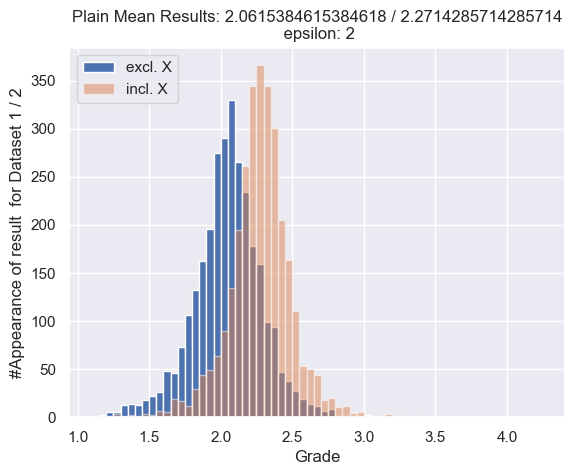

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style="darkgrid")

# To demonstrate effect, do some more iterations
epsilon = 2
binsize = 0.05
plot_from = 1.1
plot_to = 4.3
diff_priv_mean = BoundedMean(epsilon, lower_bound = best_possible_grade, upper_bound = worst_possible_grade, dtype="float")

def generate_and_plot(df1, df2, column_name):
    mean_grade_plain1 = df1[column_name].mean()
    mean_grade_plain2 = df2[column_name].mean()
    diff_priv_means1 = []
    diff_priv_means2 = []
    for i in range (0, 3000):
        diff_priv_means1.append(diff_priv_mean.quick_result(list(df1[column_name])))
        diff_priv_means2.append(diff_priv_mean.quick_result(list(df2[column_name])))

    #plt.hist(diff_priv_means1, bins=50)
    #plt.hist(diff_priv_means2, bins=50, alpha = 0.5)
    plt.hist(diff_priv_means1, bins=np.arange(plot_from, plot_to, binsize), label = "excl. X")
    plt.hist(diff_priv_means2, bins=np.arange(plot_from, plot_to, binsize), alpha = 0.5, label = "incl. X")
    plt.ylabel("#Appearance of result  for Dataset 1 / 2")
    plt.xlabel("Grade")
    plt.title("Plain Mean Results: %s / %s\n epsilon: %s" %(mean_grade_plain1, mean_grade_plain2, epsilon))
    plt.legend(loc="upper left")
    plt.show()
    
generate_and_plot(student_df, student_df2, "Grade")


As we see, the differentially private ("noised") results spread across the whole spectrum of available grades but in most cases revolve around the actual mean of respective datasets. We can thus say that "in most cases, results are 'quite' accurate" -- exactly what we intended by introducing the laplacian distribution. 

Still, however, result probabilities between both dataset differ a bit. This results from the epsilon value we used. Given above explanations, what can we thus expect from setting different values for epsilon and re-plotting the results?

Basically, we can expect:

* lower epsilons (such as 0.2 or 0.1) will lead to both histograms being less distinguishable (producing higher cross-dataset privacy / anonymity) but at the same time produce less "spiky" distibutions around the actual mean (and, thus, a lower accuracy of provided results)
* higher epsilons (such as 2.5), in turn, produce results more accurately reflecting actual means but lead to more distinguishable histograms, exposing studentX to the "difference-attack" initially mentioned

When playing around with different epsilons and executing the above code block for them, we see these assumptions to hold. For low epsilons -- which we want to have in order to provide higher epsilon-privacy -- the accuracy does, however, drop significantly and it becomes questionable whether they do actually provide value for analyses. This is mainly due to the very small size of our example dataset. Let us therefore inflate it a bit.

## Increasing Dataset Size

To demonstrate the effect of bigger datasets, let us first generate two new datasets by simply appending our initial one to itself without and with studentX included, respectively. We thus have one dataset simply including each data point from the initial one twice and one dataset that additionally includes student X. For these, we generate the same plots with the same value for epsilon as above:

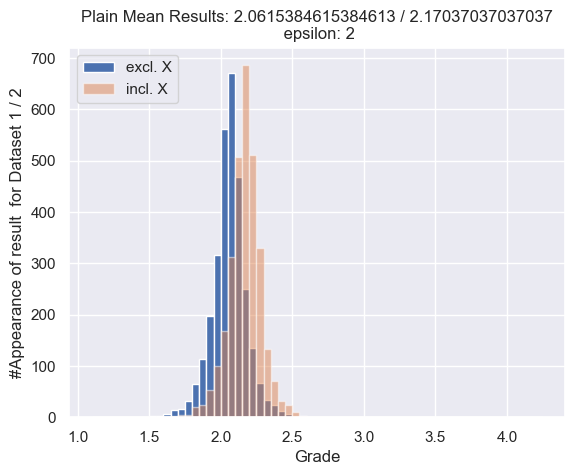

In [25]:
#student_df_inflated1 = student_df.append(student_df.copy(), ignore_index = True)
#student_df_inflated2 = student_df2.append(student_df.copy(), ignore_index = True)
#https://stackoverflow.com/questions/75956209/error-dataframe-object-has-no-attribute-append
student_df_inflated1 = pd.concat([student_df, student_df], ignore_index=True)
student_df_inflated2 =pd.concat([student_df2, student_df], ignore_index=True)
generate_and_plot(student_df_inflated1, student_df_inflated2, "Grade")

As we see, larger datasets seem to produce more accurate results or, more precisely, produce results of higher accuracy with a higher probability than smaller datasets. Let us take this even furter and append the initial dataset several times:

2613


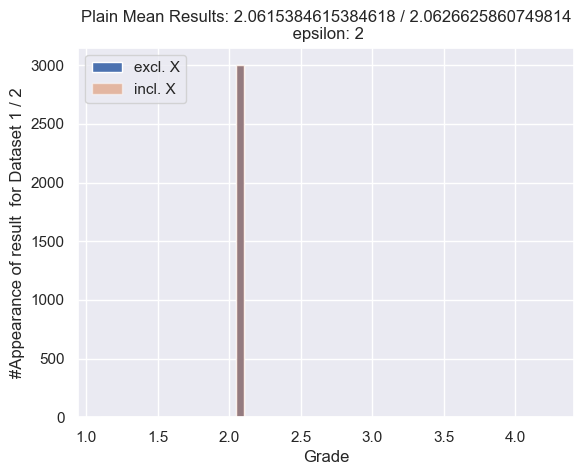

In [27]:
student_df_more_inflated1 = student_df_inflated1
student_df_more_inflated2 = student_df_inflated2
for i in range (1,200):
    student_df_more_inflated1 = pd.concat([student_df_more_inflated1, student_df.copy()], ignore_index=True)
    student_df_more_inflated2 = pd.concat([student_df_more_inflated2, student_df.copy()], ignore_index=True)

generate_and_plot(student_df_more_inflated1, student_df_more_inflated2, "Grade")

.... ok, this approach seems to have its limits. Adding the same, rather small dataset over and over again will probably not help. In addition, our student dataset is quite biased to higher degrees and, finally, does not illustrate real-world industry applications of differential provacy so well. Let us therefore briefly switch to another use-case with another, more realistic and, most importantly, larger dataset.

## An Insurance Use-Case for Differential Privacy

Let us assume an insurance use-case where customers' base and contract data as well as data about costs they caused are held some centralized, well-protected databases. Let us, assume that the product development or the marketing department is wondering whether customers that hold a bike-theft-insurance but no health insurance yet should be given special offers (assuming that bike holders a welcome health-insurance customers). However, providing the product development or marketing department with access to the internal database is nothing that could be thought of, given the sensitivity of data stored. providing raw aggregates is also not an optuion due to the possibility of difference attacks. However, we might think of differentially private queries again.

Let us, thus, for illustrative reasons assume that we have such a dataset at hand, which represents a joint via from different databases. This dataset comprises 

* Basic information about customers holding health insurance
* information whether these also have a bike-theft insurance and 
* the amount of costs caused under their health insurance within one year

We can load such an example dataset from an external source and print the first lines from this dataset as done below:

In [28]:
# get some larger sample data
url = "https://raw.githubusercontent.com/fpallas/DiffPriv-demo/main/insurance-data.csv"
insurance_df = pd.read_csv(url, sep=",")
insurance_df.head()

,age,sex,bmi,children,bike insured,region,charges
0,19,female,27.900,0,False,southwest,16884.92400
1,18,male,33.770,1,True,southeast,1725.55230
2,28,male,33.000,3,True,southeast,4449.46200
3,33,male,22.705,0,True,northwest,21984.47061
4,32,male,28.880,0,True,northwest,3866.85520


From this dataset, we generate two subsets, distinguishing between holders ("cyclists") and non-holders ("noncyclists") of a bike-theft insurance:

In [29]:
cyclists_df1 = insurance_df[insurance_df["bike insured"] == True]
noncyclists_df1 = insurance_df[insurance_df["bike insured"] == False]
cyclists_df1.head()

,age,sex,bmi,children,bike insured,region,charges
1,18,male,33.770,1,True,southeast,1725.55230
2,28,male,33.000,3,True,southeast,4449.46200
3,33,male,22.705,0,True,northwest,21984.47061
4,32,male,28.880,0,True,northwest,3866.85520
5,31,female,25.740,0,True,southeast,3756.62160


Now lets generate a second dataset that distinguishes by just one entry (such as "with/without student X" above) for each of these datasets, respectively. We do so by just dropping one entry:

In [30]:
cyclists_df2 = cyclists_df1.copy().drop([3])
noncyclists_df2 = noncyclists_df1.copy().drop([23])
cyclists_df2.head()

,age,sex,bmi,children,bike insured,region,charges
1,18,male,33.77,1,True,southeast,1725.5523
2,28,male,33.00,3,True,southeast,4449.4620
4,32,male,28.88,0,True,northwest,3866.8552
5,31,female,25.74,0,True,southeast,3756.6216
6,46,female,33.44,1,True,southeast,8240.5896


Now, lets first start with differential privacy as we did in our student example above: For both datasets of cyclists (differing from each other by just one entry), we calculate the plain mean and the differentially private mean: 

In [32]:
epsilon = 0.01
# now we use BoundedMean with min and max values from insurance table
diff_priv_mean = BoundedMean(epsilon, lower_bound = 0.0, upper_bound = cyclists_df1["charges"].max(), dtype="float")

mean_costs_plain1 = cyclists_df1["charges"].mean()
mean_costs_diffPriv1 = diff_priv_mean.quick_result(list(cyclists_df1["charges"]))
mean_costs_plain2 = cyclists_df2["charges"].mean()
mean_costs_diffPriv2 = diff_priv_mean.quick_result(list(cyclists_df2["charges"]))
print("Mean costs Dataset1 (incl. X):\nPlain   : %s\nDiffPriv: %s" %(mean_costs_plain1, mean_costs_diffPriv1))
print("Mean grades Dataset2 (excl. X):\nPlain   : %s\nDiffPriv: %s" %(mean_costs_plain2, mean_costs_diffPriv2))

Mean costs Dataset1 (incl. X):
Plain   : 8434.268297856204
DiffPriv: 9356.828180862303
Mean grades Dataset2 (excl. X):
Plain   : 8421.521164919097
DiffPriv: 12970.19012963527


Again, we see the differentially private results to differ from the plain ones in one direction or the other. Even though they are quite close to the actual mean, we couldn't distinguish between results coming from the ```_df1```- and the ```_df2```-dataset.

To get an even better feeling, try to play around with repeatedly executing above code, also with different values for epsilon -- or just do so in the histogram-plotting version given below. Again:

* What changes are to be expected when setting epsilon to a very small value (such as 0.0001)? 
* What for higher epsilon (such as, say, 0.3)?

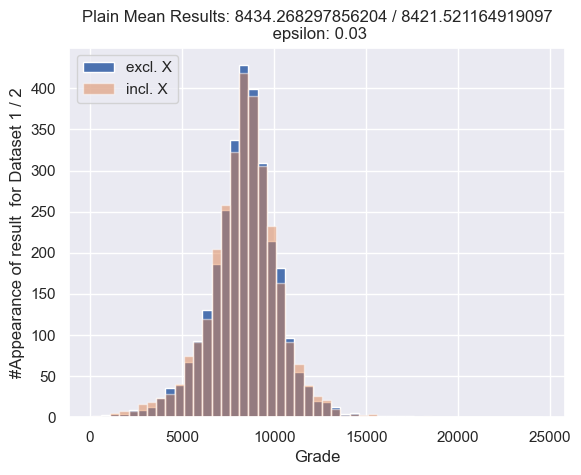

In [46]:
epsilon = 0.03
diff_priv_mean = BoundedMean(epsilon, lower_bound = 0.0, upper_bound = cyclists_df1["charges"].max(), dtype="float")
binsize = 500
plot_from = 100
#plot_to = insurance_df["charges"].max()
plot_to = 25000
generate_and_plot(cyclists_df1, cyclists_df2, "charges")

So, with epsilon appropriately chosen, we can hardly tell the difference between the two cyclists-datasets while still getting quite accurate results. Every single customer is therefore not exposed to a risk of their privacy being compromised based on results for the two datasets being compared and results are nonetheless meaningful.

When doing the same for the dataset of those that do not hold a bike-theft-insurance and plotting both histograms besides each other (ignore the captions), we can see that and how these differentially private results may very well support business decisions like the one raised above -- without significantly infringing covered data subjects' privacy or anonymity: 

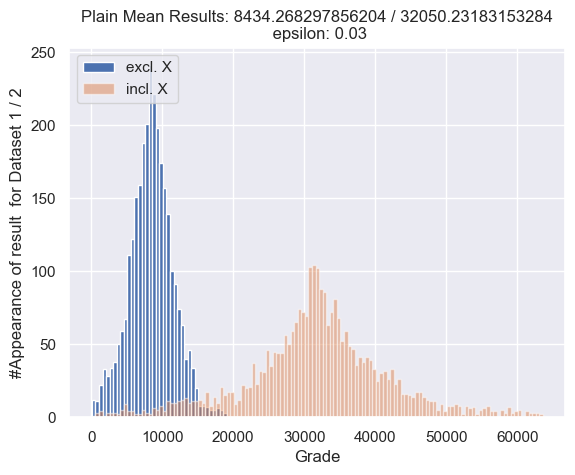

In [35]:
epsilon = 0.03
diff_priv_mean = BoundedMean(epsilon, lower_bound = 0.0, upper_bound = insurance_df["charges"].max(), dtype="float")
plot_from = 100
plot_to = insurance_df["charges"].max()
#plot_to = 50000
generate_and_plot(cyclists_df1, noncyclists_df1, "charges")

So, these were the histograms for executing the differentially private queries thousands of times. This is, however, not what is meant to be done in practice (more on this at another occasion). Instead, the intention is that each query is only executed once. When we do this, we can see that even then, it would be quite obvious what conclusions to draw from the differentially private queries:

In [37]:
epsilon = 0.01
# now we use BoundedMean with min and max values from insurance table
diff_priv_mean = BoundedMean(epsilon, lower_bound = 0.0, upper_bound = insurance_df["charges"].max(), dtype="float")
mean_costs_plain1 = cyclists_df1["charges"].mean()
mean_costs_diffPriv1 = diff_priv_mean.quick_result(list(cyclists_df1["charges"]))
mean_costs_plain2 = noncyclists_df1["charges"].mean()
mean_costs_diffPriv2 = diff_priv_mean.quick_result(list(noncyclists_df1["charges"]))
print("Mean costs Dataset1 (cyclists):\nPlain   : %s\nDiffPriv: %s" %(mean_costs_plain1, mean_costs_diffPriv1))
print("Mean grades Dataset2 (noncyclists):\nPlain   : %s\nDiffPriv: %s" %(mean_costs_plain2, mean_costs_diffPriv2))

Mean costs Dataset1 (cyclists):
Plain   : 8434.268297856204
DiffPriv: 10884.20566674383
Mean grades Dataset2 (noncyclists):
Plain   : 32050.23183153284
DiffPriv: 32618.74955866818


On this basis, even without knowing the actual plain mean values, the product development department may very well come to the conclucion that: 

**Yes, holders of bike-thef-insurance should definitely be given special offers for private health insurance as they do - on average - cause way lower costs.**

Our quick Demo & Tutorial comes to an end here. Feel free to play around with above code and implement your own, privacy-friendly data analytics on the basis of what you learned herein.

In case you have any comments, questions, suggestions, ... - feel free to get in touch via email: [fp@ise.tu-berlin.de](mailto:fp@ise.tu-berlin.de)